In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates     pkgs/main::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi              pkgs/main::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0
  openssl              pkgs/main::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


<h3>Loading New York Data</h3>

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    print('Data Loaded')

Data Loaded


<h3>Explore Data</h3>

In [6]:
neighborhoods_data = newyork_data['features']

In [7]:
#explore data
neighborhoods_data[100]

{'type': 'Feature',
 'id': 'nyu_2451_34572.101',
 'geometry': {'type': 'Point',
  'coordinates': [-73.99427936255978, 40.71561842231432]},
 'geometry_name': 'geom',
 'properties': {'name': 'Chinatown',
  'stacked': 1,
  'annoline1': 'Chinatown',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Manhattan',
  'bbox': [-73.99427936255978,
   40.71561842231432,
   -73.99427936255978,
   40.71561842231432]}}

<h3>Create Pandas Dataframe from Json Data</h3>

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h3>Display Data pionts on map using Folium</h3>

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<h3> FourSquare Credential</h3>

In [13]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MRS1Y54TM1DJBGNJUHSVD2DBMVHGVDVBCYS00F0TGNTMFLR2
CLIENT_SECRET:03DR0DS3MIDUUEEPIQSUB0X4C1SJPZNIQXBANJLFDZ2LUOOI


In [14]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [15]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

<h3>Use FourSquare API for getting details of Neighbourhood of NewYork</h3>

In [15]:
LIMIT = 100
radius = 500

In [16]:

def getNearbyVenues(Borough,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough,name, lat, lng in zip(Borough,names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:

neighborhoods_values = getNearbyVenues(Borough=neighborhoods['Borough'],names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print(neighborhoods_values.shape)

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

<h3>Explore filtered data of Neighbourhood obtained through FOurSquare</h3>

In [18]:
neighborhoods_values.head(5)

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Bronx    Wakefield              40.894705              -73.847201   
1   Bronx    Wakefield              40.894705              -73.847201   
2   Bronx    Wakefield              40.894705              -73.847201   
3   Bronx    Wakefield              40.894705              -73.847201   
4   Bronx    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [19]:
print(neighborhoods_values.shape)
neighborhoods_values.head(10)

(9874, 8)


Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Bronx    Wakefield              40.894705              -73.847201   
1   Bronx    Wakefield              40.894705              -73.847201   
2   Bronx    Wakefield              40.894705              -73.847201   
3   Bronx    Wakefield              40.894705              -73.847201   
4   Bronx    Wakefield              40.894705              -73.847201   
5   Bronx    Wakefield              40.894705              -73.847201   
6   Bronx    Wakefield              40.894705              -73.847201   
7   Bronx    Wakefield              40.894705              -73.847201   
8   Bronx    Wakefield              40.894705              -73.847201   
9   Bronx   Co-op City              40.874294              -73.829939   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop  
5             Shell       40.894187       -73.845862     Gas Station  
6            Subway       40.890468       -73.849152  Sandwich Place  
7      Central Deli       40.896728       -73.844387   Deli / Bodega  
8   Koss Quick Wash       40.891281       -73.849904      Laundromat  
9    Capri II Pizza       40.876374       -73.829940     Pizza Place

In [23]:
neighborhoods_values.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      30                      30   
Annadale                                      15                      15   
Arden Heights                                  5                       5   
Arlington                                      6                       6   
Arrochar                                      20                      20   
Arverne                                       18                      18   
Astoria                                       92                      92   
Astoria Heights                               13                      13   
Auburndale                                    18                      18   
Bath Beach                                    49                      49   
Battery Park City                             61                      61   
Bay Ridge                                     86                      86   
Bay Terrace                                   46                      46   
Baychester                                    19                      19   
Bayside                                       69                      69   
Bayswater                                      3                       3   
Bedford Park                                  40                      40   
Bedford Stuyvesant                            30                      30   
Beechhurst                                    12                      12   
Bellaire                                      12                      12   
Belle Harbor                                  17                      17   
Bellerose                                     20                      20   
Belmont                                      100                     100   
Bensonhurst                                   34                      34   
Bergen Beach                                   7                       7   
Blissville                                    16                      16   
Bloomfield                                     5                       5   
Boerum Hill                                   93                      93   
Borough Park                                  25                      25   
Breezy Point                                   5                       5   
Briarwood                                     10                      10   
Brighton Beach                                44                      44   
Broad Channel                                  6                       6   
Broadway Junction                             12                      12   
Bronxdale                                     13                      13   
Brooklyn Heights                             100                     100   
Brookville                                     1                       1   
Brownsville                                   16                      16   
Bulls Head                                    46                      46   
Bushwick                                      74                      74   
Butler Manor                                   5                       5   
Cambria Heights                               13                      13   
Canarsie                                       9                       9   
Carnegie Hill                                 84                      84   
Carroll Gardens                              100                     100   
Castle Hill                                    7                       7   
Castleton Corners                             15                      15   
Central Harlem                                45                      45   
Charleston                                    28                      28   
Chelsea                                      107                     107   
Chinatown                                    100                     100   

In [20]:
print('There are {} uniques categories.'.format(len(neighborhoods_values['Venue Category'].unique())))

There are 430 uniques categories.


<h3>Include Velue Category in Dataframe as one hot vector</h3>

In [21]:
# one hot encoding
neighborhoods_onehot = pd.get_dummies(neighborhoods_values[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
neighborhoods_onehot['Neighborhood'] = neighborhoods_values['Neighborhood'] 
neighborhoods_onehot['Borough'] = neighborhoods_values['Borough']
# move neighborhood column to the first column
fixed_columns = [neighborhoods_onehot.columns[-1]] + list(neighborhoods_onehot.columns[:-1])
neighborhoods_onehot = neighborhoods_onehot[fixed_columns]

neighborhoods_onehot.head()

Borough  Accessories Store  Adult Boutique  Afghan Restaurant  \
0   Bronx                  0               0                  0   
1   Bronx                  0               0                  0   
2   Bronx                  0               0                  0   
3   Bronx                  0               0                  0   
4   Bronx                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Animal Shelter  \
0                   0                 0                    0               0   
1                   0                 0                    0               0   
2                   0                 0                    0               0   
3                   0                 0                    0               0   
4                   0                 0                    0               0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0       0                 0                       0   
1             0       0                 0                       0   
2             0       0                 0                       0   
3             0       0                 0                       0   
4             0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   
3                 0                   0           0                      0   
4                 0                   0           0                      0   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                    0                0          0           0           0   
1                    0                0          0           0           0   
2                    0                0          0           0           0   
3                    0                0          0           0           0   
4                    0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Basketball Stadium  Bath House  Beach  Beach Bar  Bed & Breakfast  \
0                   0           0      0          0                0   
1                   0           0      0          0                0   
2                   0           0      0          0                0   
3                   0           0      0          0                0   
4                   0           0      0          0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0       

<h3> check whether Indian Restaurant exist in Dataframe</h3>

In [71]:
test_df=neighborhoods_onehot[['Neighborhood','Borough']]

In [72]:
test_df.head()

Neighborhood Borough
0    Wakefield   Bronx
1    Wakefield   Bronx
2    Wakefield   Bronx
3    Wakefield   Bronx
4    Wakefield   Bronx

In [73]:
borough_neigh_map=test_df.drop_duplicates(subset=['Neighborhood','Borough'])

In [83]:
neighborhoods_onehot = neighborhoods_onehot.join(test_df.set_index("Neighborhood"), on="Neighborhood", lsuffix='_left', rsuffix='_right')

In [24]:
neighborhoods_onehot.head()

Borough  Accessories Store  Adult Boutique  Afghan Restaurant  \
0   Bronx                  0               0                  0   
1   Bronx                  0               0                  0   
2   Bronx                  0               0                  0   
3   Bronx                  0               0                  0   
4   Bronx                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Animal Shelter  \
0                   0                 0                    0               0   
1                   0                 0                    0               0   
2                   0                 0                    0               0   
3                   0                 0                    0               0   
4                   0                 0                    0               0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0       0                 0                       0   
1             0       0                 0                       0   
2             0       0                 0                       0   
3             0       0                 0                       0   
4             0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   
3                 0                   0           0                      0   
4                 0                   0           0                      0   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                    0                0          0           0           0   
1                    0                0          0           0           0   
2                    0                0          0           0           0   
3                    0                0          0           0           0   
4                    0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Basketball Stadium  Bath House  Beach  Beach Bar  Bed & Breakfast  \
0                   0           0      0          0                0   
1                   0           0      0          0                0   
2                   0           0      0          0                0   
3                   0           0      0          0                0   
4                   0           0      0          0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0       

In [84]:
neighborhoods_grouped = neighborhoods_onehot.groupby('Neighborhood').mean().reset_index()
len(neighborhoods_grouped)
neighborhoods_grouped.head(3)

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Annadale                0.0             0.0                0.0   
2  Arden Heights                0.0             0.0                0.0   

   African Restaurant  Airport Terminal  American Restaurant  Animal Shelter  \
0                 0.0               0.0             0.033333             0.0   
1                 0.0               0.0             0.066667             0.0   
2                 0.0               0.0             0.000000             0.0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0           0.0     0.0               0.0                     0.0   
1           0.0     0.0               0.0                     0.0   
2           0.0     0.0               0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0          0.0         0.0                  0.0                   0.0   
1          0.0         0.0                  0.0                   0.0   
2          0.0         0.0                  0.0                   0.0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0               0.0                 0.0         0.0                    0.0   
1               0.0                 0.0         0.0                    0.0   
2               0.0                 0.0         0.0                    0.0   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                  0.0              0.0        0.0         0.0         0.0   
1                  0.0              0.0        0.0         0.0         0.0   
2                  0.0              0.0        0.0         0.0         0.0   

     Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.033333   0.0  0.0             0.0               0.0               0.0   
1  0.066667   0.0  0.0             0.0               0.0               0.0   
2  0.000000   0.0  0.0             0.0               0.0               0.0   

   Basketball Stadium  Bath House  Beach  Beach Bar  Bed & Breakfast  \
0                 0.0         0.0    0.0        0.0              0.0   
1                 0.0         0.0    0.0        0.0              0.0   
2                 0.0         0.0    0.0        0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0       0.0          0.0         0.0            0.0                       0.0   
1       0.0          0.0         0.0            0.0                       0.0   
2       0.0          0.0         0.0            0.0                       0.0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0        0.0    0.033333     0.0         0.0            0.0        0.0   
1        0.0    0.000000     0.0         0.0            0.0        0.0   
2        0.0    0.000000     0.0         0.0            0.0        0.0   

   Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  \
0       0.0            0.0         0.0                   0.0        0.033333   
1       0.0            0.0         0.0                   0.0        0.000000   
2       0.0            0.0         0.0                   0.0        0.000000   

   Brewery  Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  \
0      0.0          0.0     0.0              0.0     0.0       0.0   
1      0.0          0.0     0.0              0.0     0.0       0.0   
2      0.0          0.0     0.0              0.0     0.0       0.0   

   Burger Joint  Burmese Restaurant  Burrito Place  Bus Line  Bus Station  \
0           0.0                 0.0            0.0       0.0          0.0   
1           0.0                 0.0            0.0       0.0          0.0   
2           0.0                 0.0            0.0       0.0          0.0   

   Bus Stop  Business Service  Butcher  Cafeteria  Café

In [85]:
borough_neigh_map.head()

Neighborhood Borough
0     Wakefield   Bronx
9    Co-op City   Bronx
28  Eastchester   Bronx
50    Fieldston   Bronx
53    Riverdale   Bronx

In [86]:
neighborhoods_grouped = neighborhoods_grouped.join(borough_neigh_map.set_index("Neighborhood"), on="Neighborhood")

In [87]:
#neighborhoods_grouped=neighborhoods_grouped.drop_duplicates( keep=False)
neighborhoods_grouped.head(10)

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0         Allerton           0.000000             0.0                0.0   
1         Annadale           0.000000             0.0                0.0   
2    Arden Heights           0.000000             0.0                0.0   
3        Arlington           0.000000             0.0                0.0   
4         Arrochar           0.000000             0.0                0.0   
5          Arverne           0.000000             0.0                0.0   
6          Astoria           0.000000             0.0                0.0   
7  Astoria Heights           0.000000             0.0                0.0   
8       Auburndale           0.000000             0.0                0.0   
9       Bath Beach           0.020408             0.0                0.0   

   African Restaurant  Airport Terminal  American Restaurant  Animal Shelter  \
0                 0.0               0.0             0.033333             0.0   
1                 0.0               0.0             0.066667             0.0   
2                 0.0               0.0             0.000000             0.0   
3                 0.0               0.0             0.166667             0.0   
4                 0.0               0.0             0.000000             0.0   
5                 0.0               0.0             0.000000             0.0   
6                 0.0               0.0             0.010870             0.0   
7                 0.0               0.0             0.000000             0.0   
8                 0.0               0.0             0.055556             0.0   
9                 0.0               0.0             0.000000             0.0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0           0.0     0.0               0.0                     0.0   
1           0.0     0.0               0.0                     0.0   
2           0.0     0.0               0.0                     0.0   
3           0.0     0.0               0.0                     0.0   
4           0.0     0.0               0.0                     0.0   
5           0.0     0.0               0.0                     0.0   
6           0.0     0.0               0.0                     0.0   
7           0.0     0.0               0.0                     0.0   
8           0.0     0.0               0.0                     0.0   
9           0.0     0.0               0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0          0.0         0.0                  0.0                   0.0   
1          0.0         0.0                  0.0                   0.0   
2          0.0         0.0                  0.0                   0.0   
3          0.0         0.0                  0.0                   0.0   
4          0.0         0.0                  0.0                   0.0   
5          0.0         0.0                  0.0                   0.0   
6          0.0         0.0                  0.0                   0.0   
7          0.0         0.0                  0.0                   0.0   
8          0.0         0.0                  0.0                   0.0   
9          0.0         0.0                  0.0                   0.0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0          0.000000            0.000000         0.0                    0.0   
1          0.000000            0.000000         0.0                    0.0   
2          0.000000            0.000000         0.0                    0.0   
3          0.000000            0.000000         0.0                    0.0   
4          0.000000            0.050000         0.0                    0.0   
5          0.000000            0.000000         0.0                    0.0   
6          0.000000            0.000000         0.0                    0.0   
7          0.000000            0.000000         0.0                    0.0   
8          0.000000   

In [30]:
neighborhoods_grouped['Indian Restaurant']

0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
0      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
1      0.000000
2      0.000000
2      0.000000
2      0.000000
2      0.000000
2      0.000000
3      0.000000
3      0.000000
3      0.000000
3      0.000000
3      0.000000
3      0.000000
4      0.000000
4      0.000000
4      0.000000
4      0.000000
4      0.000000
4      0.000000
4      0

In [79]:
len(neighborhoods_grouped[neighborhoods_grouped["Indian Restaurant"] > 0])

49

In [80]:
neighborhoods_grouped["Borough"]

Neighborhood
Allerton                             Bronx
Annadale                     Staten Island
Arden Heights                Staten Island
Arlington                    Staten Island
Arrochar                     Staten Island
Arverne                             Queens
Astoria                             Queens
Astoria Heights                     Queens
Auburndale                          Queens
Bath Beach                        Brooklyn
Battery Park City                Manhattan
Bay Ridge                         Brooklyn
Bay Terrace                         Queens
Bay Terrace                  Staten Island
Baychester                           Bronx
Bayside                             Queens
Bayswater                           Queens
Bedford Park                         Bronx
Bedford Stuyvesant                Brooklyn
Beechhurst                          Queens
Bellaire                            Queens
Belle Harbor                        Queens
Bellerose                           Queen

<h3> filtering Indian Restaurant from data frame along with neighbourhood</h3>

In [88]:
to_indian = neighborhoods_grouped[["Borough","Neighborhood","Indian Restaurant"]]

In [89]:
to_indian[to_indian['Indian Restaurant']>=0]

Borough               Neighborhood  Indian Restaurant
0            Bronx                   Allerton           0.000000
1    Staten Island                   Annadale           0.000000
2    Staten Island              Arden Heights           0.000000
3    Staten Island                  Arlington           0.000000
4    Staten Island                   Arrochar           0.000000
5           Queens                    Arverne           0.000000
6           Queens                    Astoria           0.032609
7           Queens            Astoria Heights           0.000000
8           Queens                 Auburndale           0.000000
9         Brooklyn                 Bath Beach           0.020408
10       Manhattan          Battery Park City           0.000000
11        Brooklyn                  Bay Ridge           0.011628
12          Queens                Bay Terrace           0.000000
12   Staten Island                Bay Terrace           0.000000
13           Bronx                 Baychester           0.000000
14          Queens                    Bayside           0.043478
15          Queens                  Bayswater           0.000000
16           Bronx               Bedford Park           0.000000
17        Brooklyn         Bedford Stuyvesant           0.000000
18          Queens                 Beechhurst           0.000000
19          Queens                   Bellaire           0.000000
20          Queens               Belle Harbor           0.000000
21          Queens                  Bellerose           0.000000
22           Bronx                    Belmont           0.000000
23        Brooklyn                Bensonhurst           0.000000
24        Brooklyn               Bergen Beach           0.000000
25          Queens                 Blissville           0.000000
26   Staten Island                 Bloomfield           0.000000
27        Brooklyn                Boerum Hill           0.010753
28        Brooklyn               Borough Park           0.000000
29          Queens               Breezy Point           0.000000
30          Queens                  Briarwood           0.100000
31        Brooklyn             Brighton Beach           0.000000
32          Queens              Broad Channel           0.000000
33        Brooklyn          Broadway Junction           0.000000
34           Bronx                  Bronxdale           0.000000
35        Brooklyn           Brooklyn Heights           0.020000
36          Queens                 Brookville           0.000000
37        Brooklyn                Brownsville           0.000000
38   Staten Island                 Bulls Head           0.000000
39        Brooklyn                   Bushwick           0.013514
40   Staten Island               Butler Manor           0.000000
41          Queens            Cambria Heights           0.000000
42        Brooklyn                   Canarsie           0.000000
43       Manhattan              Carnegie Hill           0.011905
44        Brooklyn            Carroll Gardens           0.000000
45           Bronx                Castle Hill           0.000000
46   Staten Island          Castleton Corners           0.000000
47       Manhattan             Central Harlem           0.000000
48   Staten Island                 Charleston           0.000000
49       Manhattan                    Chelsea           0.000000
49   Staten Island                    Chelsea           0.000000
50       Manhattan                  Chinatown           0.000000
51           Bronx                City Island           0.000000
52        Brooklyn                  City Line           0.000000
53       Manhattan               Civic Center           0.011364
54           Bronx          Claremont Village           0.000000
55           Bronx               Clason Point           0.000000
56   Staten Island                    Clifton           0.000000
57       Manhattan                    Clinton           0.000000
58        Brooklyn               Clinton Hill 

In [90]:
to_indian.head()

Borough   Neighborhood  Indian Restaurant
0          Bronx       Allerton                0.0
1  Staten Island       Annadale                0.0
2  Staten Island  Arden Heights                0.0
3  Staten Island      Arlington                0.0
4  Staten Island       Arrochar                0.0

<h1> Indians in the New York City metropolitan region<h1>

<h3>Data obtained through wekidpedia<h3>

<a href="https://en.wikipedia.org/wiki/Indians_in_the_New_York_City_metropolitan_region">link</a>

In [104]:
population_details=pd.DataFrame()

In [105]:
borough=['Brooklyn','Manhattan','Queens','Staten Island','Bronx']
#(['Bronx', 'Staten Island', 'Queens', 'Brooklyn', 'Manhattan'])

In [106]:
indian_americans=[25270,24359,144896,6646,16748]

In [107]:
population_details['Borough']=borough

In [108]:
population_details['indian_americans']=indian_americans

In [109]:
population_details.head()

Borough  indian_americans
0       Brooklyn             25270
1      Manhattan             24359
2         Queens            144896
3  Staten Island              6646
4          Bronx             16748

In [110]:
to_indian['Borough'].unique()

array(['Bronx', 'Staten Island', 'Queens', 'Brooklyn', 'Manhattan'],
      dtype=object)

In [111]:
to_indian_with_population = to_indian.join(population_details.set_index('Borough'), on='Borough')

In [114]:
to_indian_with_population.head()

Borough   Neighborhood  Indian Restaurant  indian_americans
0          Bronx       Allerton                0.0             16748
1  Staten Island       Annadale                0.0              6646
2  Staten Island  Arden Heights                0.0              6646
3  Staten Island      Arlington                0.0              6646
4  Staten Island       Arrochar                0.0              6646

In [143]:
import matplotlib as plt

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Plot of Borough with Indian American population</h2>

<BarContainer object of 5 artists>

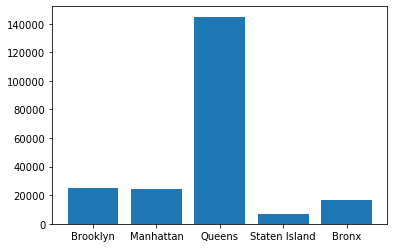

In [148]:
plt.bar(borough,indian_americans)

<h2> Brooklyn data with its Indian Restaurant mean value</h2> 

In [151]:
brooklyn=to_indian_with_population[to_indian_with_population['Borough']=='Brooklyn']

In [154]:
brooklyn.head()

Borough        Neighborhood  Indian Restaurant  indian_americans
9   Brooklyn          Bath Beach           0.020408             25270
11  Brooklyn           Bay Ridge           0.011628             25270
17  Brooklyn  Bedford Stuyvesant           0.000000             25270
23  Brooklyn         Bensonhurst           0.000000             25270
24  Brooklyn        Bergen Beach           0.000000             25270

In [156]:
#length of brooklyn as borough
len(brooklyn)

70

Text(0.5, 1.0, 'Brooklyn')

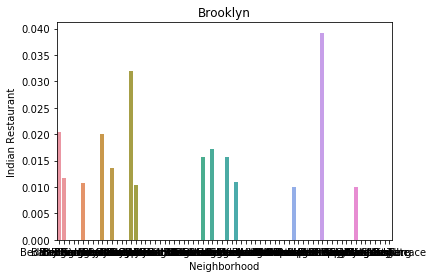

In [160]:
#display bar chart of neighbourhood and mean value of indina restaurant 
sns.barplot(x = 'Neighborhood', y = 'Indian Restaurant', data = brooklyn)
plt.title('Brooklyn')

<h2> Queens data with its Indian Restaurant mean value</h2> 

In [165]:
manhatten=to_indian_with_population[to_indian_with_population['Borough']=='manhatten']

In [166]:
manhatten.head()

Borough       Neighborhood  Indian Restaurant  indian_americans
10  Manhattan  Battery Park City           0.000000             24359
43  Manhattan      Carnegie Hill           0.011905             24359
47  Manhattan     Central Harlem           0.000000             24359
49  Manhattan            Chelsea           0.000000             24359
50  Manhattan          Chinatown           0.000000             24359

In [167]:
len(manhatten)

40

Text(0.5, 1.0, 'manhatten')

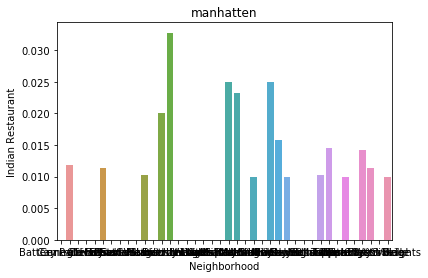

In [168]:
#display bar chart of neighbourhood and mean value of indina restaurant 
sns.barplot(x = 'Neighborhood', y = 'Indian Restaurant', data = manhatten)
plt.title('manhatten')

<h2> Queens data with its Indian Restaurant mean value</h2> 

In [170]:
queens=to_indian_with_population[to_indian_with_population['Borough']=='Queens']
print(len(queens))
queens.head()

81


Borough     Neighborhood  Indian Restaurant  indian_americans
5   Queens          Arverne           0.000000            144896
6   Queens          Astoria           0.032609            144896
7   Queens  Astoria Heights           0.000000            144896
8   Queens       Auburndale           0.000000            144896
12  Queens      Bay Terrace           0.000000            144896

Text(0.5, 1.0, 'queens')

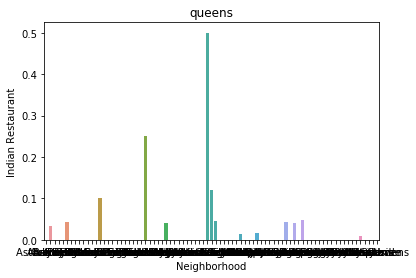

In [172]:
#display bar chart of neighbourhood and mean value of indina restaurant 
sns.barplot(x = 'Neighborhood', y = 'Indian Restaurant', data = queens)
plt.title('queens')

<h2> Queens data with its Indian Restaurant mean value</h2> 

In [173]:
Staten=to_indian_with_population[to_indian_with_population['Borough']=='Staten Island']
print(len(Staten))
Staten.head()

63


Borough   Neighborhood  Indian Restaurant  indian_americans
1   Staten Island       Annadale                0.0              6646
2   Staten Island  Arden Heights                0.0              6646
3   Staten Island      Arlington                0.0              6646
4   Staten Island       Arrochar                0.0              6646
12  Staten Island    Bay Terrace                0.0              6646

Text(0.5, 1.0, 'Staten')

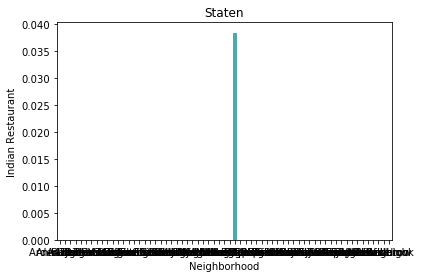

In [174]:
#display bar chart of neighbourhood and mean value of indina restaurant 
sns.barplot(x = 'Neighborhood', y = 'Indian Restaurant', data = Staten)
plt.title('Staten')

<h2> Queens data with its Indian Restaurant mean value</h2> 

In [176]:
Bronx=to_indian_with_population[to_indian_with_population['Borough']=='Bronx']
print(len(Bronx))
Bronx.head()

52


Borough  Neighborhood  Indian Restaurant  indian_americans
0    Bronx      Allerton                0.0             16748
13   Bronx    Baychester                0.0             16748
16   Bronx  Bedford Park                0.0             16748
22   Bronx       Belmont                0.0             16748
34   Bronx     Bronxdale                0.0             16748

Text(0.5, 1.0, 'Bronx')

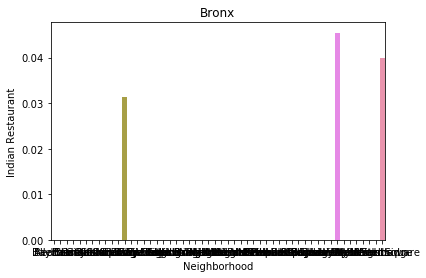

In [177]:
#display bar chart of neighbourhood and mean value of indina restaurant 
sns.barplot(x = 'Neighborhood', y = 'Indian Restaurant', data = Bronx)
plt.title('Bronx')

<h3>Apply <b>k mean Algorithm</b> </h3>

In [115]:
#apply k mean to to_indian dataframe based on its mean value
from sklearn.cluster import KMeans
toclusters = 4

to_clustering = to_indian.drop(["Neighborhood","Borough"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=1,precompute_distances='auto')
kmeans.fit_transform(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
      dtype=int32)

In [116]:
#print labels
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [129]:
#add Predicted class to the to_indian dataframe
to_merged = to_indian.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_



In [120]:
#display dataframe with label
to_merged.head()

Borough   Neighborhood  Indian Restaurant  Cluster Labels
0          Bronx       Allerton                0.0               0
1  Staten Island       Annadale                0.0               0
2  Staten Island  Arden Heights                0.0               0
3  Staten Island      Arlington                0.0               0
4  Staten Island       Arrochar                0.0               0

In [127]:
#join Dataframes
temp_neighborhood=neighborhoods_values.drop(columns='Borough')
temp_neighborhood.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [130]:
to_merged = to_merged.join(temp_neighborhood.set_index("Neighborhood"), on="Neighborhood")
print(to_merged.shape)


(10202, 10)


<h4>Explore joined dataframe</h4>

In [131]:
to_merged.head(10)

Borough Neighborhood  Indian Restaurant  Cluster Labels  \
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   
0   Bronx     Allerton                0.0               0   

   Neighborhood Latitude  Neighborhood Longitude                       Venue  \
0              40.865788              -73.859319         Domenick's Pizzeria   
0              40.865788              -73.859319  Bronx Martial Arts Academy   
0              40.865788              -73.859319                White Castle   
0              40.865788              -73.859319                     Dunkin'   
0              40.865788              -73.859319           Sal & Doms Bakery   
0              40.865788              -73.859319                        IHOP   
0              40.865788              -73.859319                 Dollar Tree   
0              40.865788              -73.859319              Domino's Pizza   
0              40.865788              -73.859319   Popeyes Louisiana Kitchen   
0              40.865788              -73.859319                    Rite Aid   

   Venue Latitude  Venue Longitude        Venue Category  
0       40.865576       -73.858124           Pizza Place  
0       40.865721       -73.857529     Martial Arts Dojo  
0       40.866065       -73.862307  Fast Food Restaurant  
0       40.865204       -73.859007            Donut Shop  
0       40.865377       -73.855236          Dessert Shop  
0       40.865728       -73.862460        Breakfast Spot  
0       40.866239       -73.861546        Discount Store  
0       40.866363       -73.861798           Pizza Place  
0       40.866786       -73.861208   Fried Chicken Joint  
0       40.865949       -73.860922              Pharmacy

In [132]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

Borough               Neighborhood  Indian Restaurant  Cluster Labels  \
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
222    Queens            Queensboro Hill           0.043478               3   
58   Brooklyn               Clinton Hill           0.031915               3   

     Neighborhood Latitude  Neighborhood Longitude                  Venue  \
219              40.658420              -73.954899           CVS pharmacy   
219              40.658420              -73.954899               Delroy's   
219              40.658420              -73.954899        Sushi Tatsu III   
222              40.744572              -73.825809  Kung Fu Xiao Long Bao   
58               40.693229              -73.967843  Brooklyn Public House   

     Venue Latitude  Venue Longitude       Venue Category  
219       40.656348       -73.950192             Pharmacy  
219       40.658121       -73.960045                 Food  
219       40.657606       -73.960396     Sushi Restaurant  
222       40.743380       -73.825741  Dumpling Restaurant  
58        40.689537       -73.969398         Cocktail Bar

In [133]:
to_merged.tail(10)

Borough               Neighborhood  Indian Restaurant  Cluster Labels  \
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
219  Brooklyn  Prospect Lefferts Gardens           0.039216               3   
222    Queens            Queensboro Hill           0.043478               3   
58   Brooklyn               Clinton Hill           0.031915               3   

     Neighborhood Latitude  Neighborhood Longitude                   Venue  \
219              40.658420              -73.954899  Charles Barkley Center   
219              40.658420              -73.954899          Red Brick Cafe   
219              40.658420              -73.954899       Ideal Food Basket   
219              40.658420              -73.954899                  Kam Po   
219              40.658420              -73.954899            Food Dynasty   
219              40.658420              -73.954899            CVS pharmacy   
219              40.658420              -73.954899                Delroy's   
219              40.658420              -73.954899         Sushi Tatsu III   
222              40.744572              -73.825809   Kung Fu Xiao Long Bao   
58               40.693229              -73.967843   Brooklyn Public House   

     Venue Latitude  Venue Longitude       Venue Category  
219       40.661581       -73.957958     Basketball Court  
219       40.660616       -73.950945           Food Court  
219       40.654825       -73.956265          Supermarket  
219       40.655558       -73.956489   Chinese Restaurant  
219       40.654862       -73.952524        Grocery Store  
219       40.656348       -73.950192             Pharmacy  
219       40.658121       -73.960045                 Food  
219       40.657606       -73.960396     Sushi Restaurant  
222       40.743380       -73.825741  Dumpling Restaurant  
58        40.689537       -73.969398         Cocktail Bar

In [ ]:
to_merged.head(10)

<h4>Group joined data frame </h4>

In [134]:
#hroup by neighbourhood as it contains repeated rows becuase of join operation
Indian_restuarant_merged_data=to_merged.groupby('Neighborhood').mean().reset_index()

In [135]:
#print length of the gruped dataframe
len(Indian_restuarant_merged_data)

302

<h3>display  Map Along with clusters  </h3>

In [136]:
#folium map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
for lat, lon, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=3,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
#display map     
map_clusters

<h3>Explore Clusters<h3>

In [137]:
#Cluster 0
Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels']==0]

Neighborhood  Indian Restaurant  Cluster Labels  \
0                Allerton           0.000000               0   
1                Annadale           0.000000               0   
2           Arden Heights           0.000000               0   
3               Arlington           0.000000               0   
4                Arrochar           0.000000               0   
5                 Arverne           0.000000               0   
7         Astoria Heights           0.000000               0   
8              Auburndale           0.000000               0   
9              Bath Beach           0.020408               0   
10      Battery Park City           0.000000               0   
11              Bay Ridge           0.011628               0   
12            Bay Terrace           0.000000               0   
13             Baychester           0.000000               0   
15              Bayswater           0.000000               0   
16           Bedford Park           0.000000               0   
17     Bedford Stuyvesant           0.000000               0   
18             Beechhurst           0.000000               0   
19               Bellaire           0.000000               0   
20           Belle Harbor           0.000000               0   
21              Bellerose           0.000000               0   
22                Belmont           0.000000               0   
23            Bensonhurst           0.000000               0   
24           Bergen Beach           0.000000               0   
25             Blissville           0.000000               0   
26             Bloomfield           0.000000               0   
27            Boerum Hill           0.010753               0   
28           Borough Park           0.000000               0   
29           Breezy Point           0.000000               0   
31         Brighton Beach           0.000000               0   
32          Broad Channel           0.000000               0   
33      Broadway Junction           0.000000               0   
34              Bronxdale           0.000000               0   
35       Brooklyn Heights           0.020000               0   
36             Brookville           0.000000               0   
37            Brownsville           0.000000               0   
38             Bulls Head           0.000000               0   
39               Bushwick           0.013514               0   
40           Butler Manor           0.000000               0   
41        Cambria Heights           0.000000               0   
42               Canarsie           0.000000               0   
43          Carnegie Hill           0.011905               0   
44        Carroll Gardens           0.000000               0   
45            Castle Hill           0.000000               0   
46      Castleton Corners           0.000000               0   
47         Central Harlem           0.000000               0   
48             Charleston           0.000000               0   
49                Chelsea           0.000000               0   
50              Chinatown           0.000000               0   
51            City Island           0.000000               0   
52              City Line           0.000000               0   
53           Civic Center           0.011364               0   
54      Claremont Village           0.000000               0   
55           Clason Point           0.000000               0   
56                Clifton           0.000000               0   
57                Clinton           0.000000               0   
59             Co-op City           0.000000               0   
60            Cobble Hill           0.010309               0   
61          College Point           0.000000               0   
62                Concord           0.000000               0   
63              Concourse           0.000000               0   
65           Coney Island           0.000000               0   
66                 Corona           0.000000 

In [138]:
#cluster 1
Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels']==1]

Neighborhood  Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
99  Floral Park               0.25               1              40.741378   

    Neighborhood Longitude  Venue Latitude  Venue Longitude  
99              -73.708847       40.737876       -73.708709

In [139]:
#cluster 2
Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels']==2]

Neighborhood  Indian Restaurant  Cluster Labels  \
142  Jamaica Estates                0.5               2   

     Neighborhood Latitude  Neighborhood Longitude  Venue Latitude  \
142              40.716805              -73.787227       40.720148   

     Venue Longitude  
142       -73.788789

In [140]:
#cluster 3
Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels']==3]

Neighborhood  Indian Restaurant  Cluster Labels  \
6                      Astoria           0.032609               3   
14                     Bayside           0.043478               3   
30                   Briarwood           0.100000               3   
58                Clinton Hill           0.031915               3   
64           Concourse Village           0.031250               3   
111                  Glen Oaks           0.040000               3   
124           Hamilton Heights           0.032787               3   
143              Jamaica Hills           0.120000               3   
145                Kew Gardens           0.044444               3   
164           Manhattan Valley           0.025000               3   
165             Manhattanville           0.023256               3   
179        Morningside Heights           0.025000               3   
189                   New Dorp           0.038462               3   
219  Prospect Lefferts Gardens           0.039216               3   
222            Queensboro Hill           0.043478               3   
225                 Ravenswood           0.041667               3   
229              Richmond Hill           0.047619               3   
276                  Unionport           0.045455               3   
298                   Woodlawn           0.040000               3   

     Neighborhood Latitude  Neighborhood Longitude  Venue Latitude  \
6                40.768509              -73.915654       40.766510   
14               40.766041              -73.774274       40.764740   
30               40.710935              -73.811748       40.711396   
58               40.693229              -73.967843       40.692859   
64               40.824780              -73.915847       40.824786   
111              40.749441              -73.715481       40.746710   
124              40.823604              -73.949688       40.824025   
143              40.711460              -73.796465       40.711021   
145              40.705179              -73.829819       40.707474   
164              40.797307              -73.964286       40.798513   
165              40.816934              -73.957385       40.816579   
179              40.808000              -73.963896       40.807353   
189              40.572572              -74.116479       40.572954   
219              40.658420              -73.954899       40.658413   
222              40.744572              -73.825809       40.743832   
225              40.761705              -73.931575       40.762239   
229              40.697947              -73.831833       40.698808   
276              40.829774              -73.850535       40.831845   
298              40.898273              -73.867315       40.898392   

     Venue Longitude  
6         -73.916297  
14        -73.771734  
30        -73.809077  
58        -73.968283  
64        -73.916888  
111       -73.714070  
124       -73.948782  
143       -73.794700  
145       -73.830656  
164       -73.966167  
165       -73.958260  
179       -73.963315  
189       -74.114646  
219       -73.956230  
222       -73.826209  
225       -73.928647  
229       -73.831939  
276       -73.851367  
298       -73.866884

<h3> finding number of neighbourhood in cluster<h3>

In [141]:
cluster_0=len(Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels'] ==0])
cluster_1=len(Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels'] ==1])
cluster_2=len(Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels'] ==2])
cluster_3=len(Indian_restuarant_merged_data[Indian_restuarant_merged_data['Cluster Labels'] ==3])

In [142]:
print("Total datapionts in clusters")
print('Cluster-0:',cluster_0)
print('Cluster-1:',cluster_1)
print('Cluster-2:',cluster_2)
print('Cluster-3:',cluster_3)

Total datapionts in clusters
Cluster-0: 281
Cluster-1: 1
Cluster-2: 1
Cluster-3: 19
